The code in this notebook generated the RMSE score of 3.099. The progress has been slow ever since. It appears that in general band of brothers and sisters around Keras and TensorFlow are suffering. 

Best Val MAE of 1.50873. 500K/6M-128/128/64/32/16/8/1 - 32/1024 - 35 Features - loss: 11.0058 - mean_absolute_error: 1.5223 - val_loss: 11.7594 - val_mean_absolute_error: 1.5686  - MacBook Processing - Modified code to add quarter of the year  - the ranking increased by 14.  Used Best Model Approach!

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [62]:
# Let's start with standard libraries
# The seed setting is an attempt to get consistent results from Keras. 
from numpy.random import seed
import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(40)
import os
import glob
import datetime 
# Define the necessary libraries required to define Keras Regression Netowrk
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print(keras.__version__)

2.8.0


In [4]:
#using four main areas for reference
JFK = (-73.7822222222, 40.6441666667)
NYC = (-74.0063889, 40.7141667)
EWR = (-74.175, 40.6897222222)
LGA = (-73.8739659, 40.7769271)

In [5]:
# if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance.
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)     

def minkowski_distance_3D(x1, x2, y1, y2, z1, z2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1) ** p) + (abs(z2 - z1) ** p)) ** (1 / p)

def calculate_direction(d_lon, d_lat):
    
    result = np.zeros(len(d_lon))
    
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    
    return result

def time_type_of_the_day(hour):
    
    time_of_the_day = 2
    
    if (hour >= 4 and hour < 7):
        time_of_the_day = 1 # Early Morning
    elif (hour >= 7 and hour < 12):
        time_of_the_day = 2 # Morning
    elif (hour >= 12 and hour < 16):
        time_of_the_day = 3 # Noon
    elif (hour >= 16 and hour < 20):
        time_of_the_day = 4 # Evening
    elif (hour >= 20 and hour < 23):
        time_of_the_day = 5 # Night
    elif (hour >= 23 and hour < 4):
        time_of_the_day = 6 # Late Night
    else:
        time_of_the_day = 2 # Morning Default

    return time_of_the_day

# The day of the week with Monday=0, Sunday=6
# 0.5 of additional surcharge between 8PM - 6AM.
# Peak hour weekday surcharge of $1 Monday-Friday between 4PM-8PM.
def peak_hours_of_the_day(hour, weekday):
    
    peak_hours = 0
    
    if (0 <= weekday <= 4) and (16 <= hour <= 20):
        peak_hours = 1
        
    return peak_hours

# The day of the week with Monday=0, Sunday=6
# 0.5 of additional surcharge between 8PM - 6AM.
# Peak hour weekday surcharge of $1 Monday-Friday between 4PM-8PM.
def surcharge_hours_of_the_day(hour):
    
    surcharge_hours = 0
    
    if (hour >= 20 or hour <= 6):
        surcharge_hours = 1
        
    return surcharge_hours

def add_travel_vector_features(df):
    
    df['delta_longitude'] = df.pickup_longitude - df.dropoff_longitude
    df['delta_latitude'] = df.pickup_latitude - df.dropoff_latitude

    df['pickup_x'] = np.cos(df.pickup_latitude) * np.cos(df.pickup_longitude)
    df['pickup_y'] = np.cos(df.pickup_latitude) * np.sin(df.pickup_longitude)
    df['pickup_z'] = np.sin(df.pickup_latitude)
    
    df['dropoff_x'] = np.cos(df.dropoff_latitude) * np.cos(df.dropoff_longitude)
    df['dropoff_y'] = np.cos(df.dropoff_latitude) * np.sin(df.dropoff_longitude)
    df['dropoff_z'] = np.sin(df.dropoff_latitude)

In [12]:
def parse_and_extract_date_time_components(df):
        
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
      
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['minute'] = df['pickup_datetime'].apply(lambda x: x.minute)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.dayofweek)
    df['weekofyear'] = df['pickup_datetime'].apply(lambda x: x.weekofyear)
    df['dayofyear'] = df['pickup_datetime'].apply(lambda x: x.dayofyear)
    df['quarterofyear'] = df['pickup_datetime'].apply(lambda x: x.quarter)
    df['days_in_month'] = df['pickup_datetime'].apply(lambda x: x.days_in_month)
    df['linear_time'] = df['pickup_datetime'].apply(lambda x: x.value // 10 ** 9)    
    df['time_type_of_the_day'] = df['pickup_datetime'].apply (lambda x: time_type_of_the_day(x.hour)) 
    df['peak_hours'] = df['pickup_datetime'].apply(lambda x: peak_hours_of_the_day(x.hour, x.dayofweek))
    df['surcharge'] = df['pickup_datetime'].apply(lambda x: surcharge_hours_of_the_day(x.hour))
    
    # Process cyclical values using sin and cosine transformations
    # These are better than one-hot encoding and helped me a lot to keep features compact.
    
    df['hour_sin'] = np.sin(df.hour * (2. * np.pi / 24))
    df['hour_cos'] = np.cos(df.hour * (2. * np.pi / 24))
 
    df['minute_sin'] = np.sin(df.minute * (2. * np.pi / 60))
    df['minute_cos'] = np.cos(df.minute * (2. * np.pi / 60))
    
    df['time_type_of_day_sin'] = np.sin(df.time_type_of_the_day * (2. * np.pi / 6))
    df['time_type_of_day_cos'] = np.cos(df.time_type_of_the_day * (2. * np.pi / 6))
    
    df['month_sin'] = np.sin((df.month - 1) * (2. * np.pi / 12))
    df['month_cos'] = np.cos((df.month - 1) * (2. * np.pi / 12))

    df['day_sin'] = np.sin((df.day - 1) * (2. * np.pi / df.days_in_month))
    df['day_cos'] = np.cos((df.day - 1) * (2. * np.pi / df.days_in_month))
    
    df['weekday_sin'] = np.sin((df.weekday - 1) * (2. * np.pi / 7))
    df['weekday_cos'] = np.cos((df.weekday - 1) * (2. * np.pi / 7))
    
    df['weekofyear_sin'] = np.sin((df.weekofyear - 1) * (2. * np.pi / 52))
    df['weekofyear_cos'] = np.cos((df.weekofyear - 1) * (2. * np.pi / 52))
  
    df['dayofyear_sin'] = np.sin((df.dayofyear - 1) * (2. * np.pi / 365))
    df['dayofyear_cos'] = np.cos((df.dayofyear - 1) * (2. * np.pi / 365))

    df['quarterofyear_sin'] = np.sin((df.quarterofyear - 1) * (2. * np.pi / 4))
    df['quarterofyear_cos'] = np.cos((df.quarterofyear - 1) * (2. * np.pi / 4))

    # Clean Up Extra Features which may not be needed
    del df['hour']
    del df['minute']
    del df['month']
    del df['day']
    del df['weekday']
    del df['days_in_month']
    del df['time_type_of_the_day']
    del df['weekofyear']
    del df['quarterofyear']    

In [13]:
# Calculate NY Manhattan Distance using longitude and lattitude
def haversine_np(lon1, lat1, lon2, lat2):
    
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    miles = 3959 * c
    
    return miles

In [87]:
# Now read the training set

# To play with only subset of the data
df_subset =  pd.read_csv('NYC_taxi_fare.csv',nrows=6000000)

# count rows with null values
print(df_subset.isnull().sum())
# Let's drop the null values
print(' Old size: %d' % len(df_subset))
df_subset = df_subset.dropna(how = 'any', axis = 'rows')

print(' New size: %d' % len(df_subset))

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    39
dropoff_latitude     39
passenger_count       0
dtype: int64
 Old size: 6000000
 New size: 5999961


In [88]:
fname = 'NYC_taxi_fare'
# Important feature here two dimensional latitude and longitudes to three dimesnional coordinate systems.
add_travel_vector_features(df_subset)

# Extract various date components.
parse_and_extract_date_time_components(df_subset)

# NEED TO CHECK THIS VALUE - PROBABLY FIND OUT THE MAXIMUM RANGE OF NEW YORK CITY LIMITS

print(fname + ' Before dropping Zero pickup longitude and latitude - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.pickup_longitude != 0.) & (df_subset.pickup_latitude != 0.)]
print(fname + ' After dropping Zero pickup longitude and latitude - New size: %d' % len(df_subset))

print(fname + ' Before dropping Zero dropoff longitude and latitude - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.dropoff_longitude != 0.) & (df_subset.dropoff_latitude != 0.)]
print(fname + ' After dropping Zero dropoff longitude and latitude - New size: %d' % len(df_subset))

print(fname + ' Before dropping really large lat and lon Outliers - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.delta_longitude.abs() < 5.0) & (df_subset.delta_latitude.abs() < 5.0)]
print(fname + ' After dropping really large lat and lon Outliers - New size: %d' % len(df_subset))

print(fname + ' Before dropping zero delta lat and long values - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.delta_longitude != 0.) & (df_subset.delta_latitude != 0.)]
print(fname + ' After dropping delta lat and long values - New size: %d' % len(df_subset))

# ADD CODE TO CHECK FOR NEGATIVE FARES
print(fname + ' Before dropping NEGATIVE FARE VALUES - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.fare_amount > 0.)]
print(fname + ' After dropping NEGATIVE FARE VALUES - New size: %d' % len(df_subset))

# ADD CODE TO CHECK FOR ZERO PASSENGER COUNTS
print(fname + ' Before dropping Zero Passenger Counts - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.passenger_count > 0) & (df_subset.passenger_count < 7)]
print(fname + ' After dropping Zero Passenger Counts - New size: %d' % len(df_subset))


/Users/wangjunren/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()


NYC_taxi_fare Before dropping Zero pickup longitude and latitude - Old size: 5999961
NYC_taxi_fare After dropping Zero pickup longitude and latitude - New size: 5885814
NYC_taxi_fare Before dropping Zero dropoff longitude and latitude - Old size: 5885814
NYC_taxi_fare After dropping Zero dropoff longitude and latitude - New size: 5880480
NYC_taxi_fare Before dropping really large lat and lon Outliers - Old size: 5880480
NYC_taxi_fare After dropping really large lat and lon Outliers - New size: 5879001
NYC_taxi_fare Before dropping zero delta lat and long values - Old size: 5879001
NYC_taxi_fare After dropping delta lat and long values - New size: 5813825
NYC_taxi_fare Before dropping NEGATIVE FARE VALUES - Old size: 5813825
NYC_taxi_fare After dropping NEGATIVE FARE VALUES - New size: 5813504
NYC_taxi_fare Before dropping Zero Passenger Counts - Old size: 5813504
NYC_taxi_fare After dropping Zero Passenger Counts - New size: 5792908


In [89]:
# Extract more features for the model
df_subset['distance_in_miles'] = haversine_np(df_subset.dropoff_longitude, df_subset.dropoff_latitude, df_subset.pickup_longitude, df_subset.pickup_latitude)

df_subset['direction'] = calculate_direction(df_subset.delta_longitude, df_subset.delta_latitude)

# JFK AS THE FRAME OF REFERENCE
df_subset['pickup_to_JFK_distance'] = haversine_np(df_subset.pickup_longitude, df_subset.pickup_latitude, JFK[0], JFK[1]) 
df_subset['dropoff_to_JFK_distance'] = haversine_np(df_subset.dropoff_longitude, df_subset.dropoff_latitude, JFK[0], JFK[1]) 

# ALSO USE EWR AS ANOTHER FRAME OF REFERENCE IF REQUIRED
df_subset['pickup_to_EWR_distance'] = haversine_np(df_subset.pickup_longitude, df_subset.pickup_latitude, EWR[0], EWR[1]) 
df_subset['dropoff_to_EWR_distance'] = haversine_np(df_subset.dropoff_longitude, df_subset.dropoff_latitude, EWR[0], EWR[1]) 

# ALSO USE LGA AS ANOTHER FRAME OF REFERENCE IF REQUIRED
df_subset['pickup_to_LGA_distance'] = haversine_np(df_subset.pickup_longitude, df_subset.pickup_latitude, LGA[0], LGA[1]) 
df_subset['dropoff_to_LGA_distance'] = haversine_np(df_subset.dropoff_longitude, df_subset.dropoff_latitude, LGA[0], LGA[1]) 

# ALSO USE NYC AS ANOTHER FRAME OF REFERENCE IF REQUIRED
df_subset['pickup_to_NYC_distance'] = haversine_np(df_subset.pickup_longitude, df_subset.pickup_latitude, NYC[0], NYC[1]) 
df_subset['dropoff_to_NYC_distance'] = haversine_np(df_subset.dropoff_longitude, df_subset.dropoff_latitude, NYC[0], NYC[1]) 

# For some reason my NN model didn't find Euclidean and Manhattan distances that important.

# Calculate Manhattan Distance between two sets of GPS coordinates
df_subset['manhattan'] = minkowski_distance(df_subset.pickup_longitude, df_subset.dropoff_longitude, 
                                           df_subset.pickup_latitude, df_subset.dropoff_latitude, 1)

# Calcualte Euclidean Distance between two sets of GPS Coordinates
df_subset['euclidean'] = minkowski_distance(df_subset.pickup_longitude, df_subset.dropoff_longitude, 
                                           df_subset.pickup_latitude, df_subset.dropoff_latitude, 2)

# Calcualte 3D Euclidean Distance between two sets 3D GPS Coordinates
df_subset['euclidean_3D'] = minkowski_distance_3D(df_subset.pickup_x, df_subset.dropoff_x, 
                                                 df_subset.pickup_y, df_subset.dropoff_y, 
                                                 df_subset.pickup_z, df_subset.dropoff_z, 2)

# Calcualte 3D Manhattan Distance between two sets 3D GPS Coordinates
df_subset['manhattan_3D'] = minkowski_distance_3D(df_subset.pickup_x, df_subset.dropoff_x, 
                                                 df_subset.pickup_y, df_subset.dropoff_y, 
                                                 df_subset.pickup_z, df_subset.dropoff_z, 1)

# ADD CODE TO CHECK FOR REALLY HIGH FARE AMOUNTS
print(fname + ' Before dropping HIGH FARE AMOUNTS - Old size: %d' % len(df_subset))
df_subset = df_subset[(df_subset.fare_amount > 1.) & (df_subset.fare_amount < 251.)]
print(fname + ' After dropping HIGH FARE AMOUNTS - New size: %d' % len(df_subset))


NYC_taxi_fare Before dropping HIGH FARE AMOUNTS - Old size: 5792908
NYC_taxi_fare After dropping HIGH FARE AMOUNTS - New size: 5792813


In [94]:
# Extract the training features and standardize the values
df_subset_x = df_subset.loc[:, [
                                'passenger_count',
                                'distance_in_miles',
                                'pickup_x',
                                'pickup_y',
                                'pickup_z',
                                'dropoff_x',
                                'dropoff_y',
                                'dropoff_z',
                                'pickup_to_JFK_distance',
                                'dropoff_to_JFK_distance',
                                'pickup_to_NYC_distance',
                                'dropoff_to_NYC_distance',
                                'delta_longitude',
                                'delta_latitude',
                                'direction',
                                'year',
                                'linear_time',
                                'peak_hours',
                                'surcharge',
                                'hour_sin',
                                'hour_cos',
                                'minute_sin',
                                'minute_cos',
                                'time_type_of_day_sin',
                                'time_type_of_day_cos',
                                'month_sin',
                                'month_cos',
                                'day_sin',
                                'day_cos',
                                'weekday_sin',
                                'weekday_cos',
                                'weekofyear_sin',
                                'weekofyear_cos',
                                'quarterofyear_sin',
                                'quarterofyear_cos'
                                ]].values

# Extract the training label
df_subset_label = df_subset.loc[:, 'fare_amount'].values

# Standardize the training data
mean = df_subset_x.mean(axis = 0)
std = df_subset_x.std(axis = 0)

df_subset_xstd  = (df_subset_x-mean)/ std

In [95]:
num_validation_samples = 800000
num_test_samples = 1000000

# split input data into train/validation/test
validation_set = df_subset_xstd[:num_validation_samples]
test_set = df_subset_xstd[num_validation_samples:num_test_samples]
training_set = df_subset_xstd[num_test_samples:]

# split target data into train/validation/test
validation_label = df_subset_label[:num_validation_samples]
test_label = df_subset_label[num_validation_samples:num_test_samples]
training_label = df_subset_label[num_test_samples:]


In [96]:
training_set.shape[0]

4792813

In [97]:
NN_INPUT_SIZE = training_set.shape[1]

# Intialize the model
model = models.Sequential()

#model.add(layers.Dense(128, kernel_regularizer = regularizers.l1_l2(l1=0.001, l2=0.001), activation = 'relu', input_shape = (NN_INPUT_SIZE,)))
model.add(layers.Dense(128, kernel_initializer = 'uniform', activation = 'relu', input_shape = (NN_INPUT_SIZE,)))
#model.add(layers.Dropout(0.2))

# Add a second layer
model.add(layers.Dense(128, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(layers.Dropout(0.2))

# Add a third layer
#model.add(layers.Dense(64, kernel_regularizer = regularizers.l1_l2(l1=0.001, l2=0.001), activation = 'relu'))
model.add(layers.Dense(64, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

# Add a fourth layer
#model.add(layers.Dense(32, kernel_regularizer = regularizers.l1_l2(l1=0.001, l2=0.001), activation = 'relu'))
model.add(layers.Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

# Add a output layer without an activation function
model.add(layers.Dense(1))

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics ='mean_absolute_error')




In [98]:
# DEFINE A CALLBACK TO SAVE THE BEST MODEL WITH MINIMUM VALIDATION MAE VALUE
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpointer = ModelCheckpoint(filepath = 'NN_PredictionModel_Ref.h5', monitor = 'val_mean_absolute_error', verbose = 1, save_best_only = True, mode = 'min')

# Train the model
test_history = model.fit(training_set, training_label, shuffle=True,
                         validation_data = (validation_set, validation_label), 
                         epochs = 32, batch_size = 1024,
                         callbacks = [checkpointer])

Epoch 1/32
4674/4681 [============================>.] - ETA: 0s - loss: 17.6966 - mean_absolute_error: 2.0337
Epoch 1: val_mean_absolute_error improved from inf to 1.82265, saving model to NN_PredictionModel_Ref.h5
4681/4681 [==============================] - 13s 3ms/step - loss: 17.6914 - mean_absolute_error: 2.0335 - val_loss: 14.3016 - val_mean_absolute_error: 1.8226
Epoch 2/32
4667/4681 [============================>.] - ETA: 0s - loss: 13.7706 - mean_absolute_error: 1.7900
Epoch 2: val_mean_absolute_error improved from 1.82265 to 1.71967, saving model to NN_PredictionModel_Ref.h5
4681/4681 [==============================] - 12s 3ms/step - loss: 13.7735 - mean_absolute_error: 1.7898 - val_loss: 13.1924 - val_mean_absolute_error: 1.7197
Epoch 3/32
4666/4681 [============================>.] - ETA: 0s - loss: 12.9554 - mean_absolute_error: 1.6991
Epoch 3: val_mean_absolute_error improved from 1.71967 to 1.62973, saving model to NN_PredictionModel_Ref.h5
4681/4681 [====================

4669/4681 [============================>.] - ETA: 0s - loss: 10.9705 - mean_absolute_error: 1.5217
Epoch 24: val_mean_absolute_error did not improve from 1.50666
4681/4681 [==============================] - 13s 3ms/step - loss: 10.9700 - mean_absolute_error: 1.5217 - val_loss: 11.3323 - val_mean_absolute_error: 1.5663
Epoch 25/32
4672/4681 [============================>.] - ETA: 0s - loss: 10.9440 - mean_absolute_error: 1.5204
Epoch 25: val_mean_absolute_error improved from 1.50666 to 1.50039, saving model to NN_PredictionModel_Ref.h5
4681/4681 [==============================] - 12s 3ms/step - loss: 10.9427 - mean_absolute_error: 1.5204 - val_loss: 11.0120 - val_mean_absolute_error: 1.5004
Epoch 26/32
4674/4681 [============================>.] - ETA: 0s - loss: 10.9929 - mean_absolute_error: 1.5195
Epoch 26: val_mean_absolute_error did not improve from 1.50039
4681/4681 [==============================] - 12s 3ms/step - loss: 10.9930 - mean_absolute_error: 1.5195 - val_loss: 11.1970 - v

In [99]:
print(os.listdir(".")) 

['NN_PredictionModel_Ref.h5', 'model_dl.ipynb', 'submission.csv', 'NYC_taxi_fare.csv', '.ipynb_checkpoints']


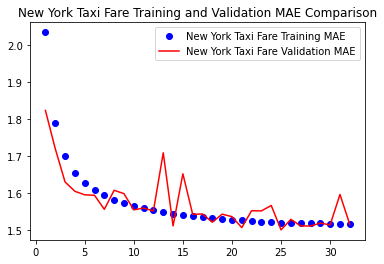

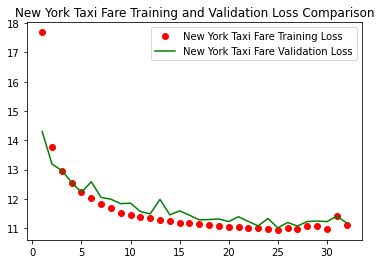

In [100]:
# PLOT THE GRAPH HERE TO TRACE MAE AND LOSS.

# forms set of Y axis values
mae = test_history.history['mean_absolute_error']
val_mae = test_history.history['val_mean_absolute_error']
loss = test_history.history['loss']
val_loss = test_history.history['val_loss']

# forms X axis values
epochs = range(1, len(mae) + 1)

# Process Training and Validation Accuracy
plt.plot(epochs, mae, 'bo', label = 'New York Taxi Fare Training MAE')
plt.plot(epochs, val_mae, 'r', label = 'New York Taxi Fare Validation MAE')
plt.title('New York Taxi Fare Training and Validation MAE Comparison')
plt.legend()
plt.show()

# Process Training and Validation Losses
plt.plot(epochs, loss, 'ro', label = 'New York Taxi Fare Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'New York Taxi Fare Validation Loss')
plt.title('New York Taxi Fare Training and Validation Loss Comparison')
plt.legend()
plt.show()

# end of if statement


In [109]:
test_mse, test_mae = model.evaluate(test_set, test_label)
print('MSE on test set:{0:.3f}\nMAE on test set:{1:.3f}'.format(test_mse,test_mae))

6250/6250 [==============================] - 5s 860us/step - loss: 12.6320 - mean_absolute_error: 1.5125
MSE on test set:12.632
MAE on test set:1.512
